<a href="https://colab.research.google.com/github/yantzan/Algorithms/blob/master/DL_DataReconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 安装或更新numpy到指定版本
!pip install numpy==1.23.5

# 安装或更新Pillow到指定版本
!pip install Pillow==9.4.0

# 安装或更新scipy到指定版本
!pip install scipy==1.11.4

# 安装或更新spams到指定版本
!pip install spams==2.6.5.4


In [18]:
!pip install --upgrade spams


In [211]:
import numpy as np
import pandas as pd
import spams
import matplotlib.pyplot as plt


In [212]:

def train_dictionary_and_get_sparse_code(Y, k, lambda1=1.0, iter_num=200):
    m, n = Y.shape
    param = {
        'K': k,
        'lambda1': lambda1,
        'numThreads': -1,
        'batchsize': 200,
        'iter': iter_num
    }
    D = spams.trainDL(Y, **param)

    # Obtain sparse code X using the trained dictionary D
    X = spams.lasso(Y, D=D, lambda1=lambda1, numThreads=-1)

    return D, X

In [264]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# 创建 MinMaxScaler 对象
scaler = MinMaxScaler()

# 加载数据
df = pd.read_csv('/content/Acc.csv', header=None)

# 使用 .iloc 进行基于位置的切片，选择所有行和前600列作为训练数据
train_data = df.iloc[:, :].values.astype(np.float64)  # 转换为 numpy array 并指定数据类型为 float64

# 选择所有行和第600列之后的数据作为测试数据
# 转换为 numpy array 并指定数据类型为 float64
test_data = df.iloc[:, 500:].values.astype(np.float64)


# # 假设df有800列，我们想随机选择300列
# random_columns = df.sample(n=300, axis=1, random_state=42).values.astype(np.float64)

# # 你现在可以使用这些随机选择的列作为你的测试数据
# test_data = random_columns
print(test_data.shape)


meas_data = df.iloc[[2, 3],500:].values.astype(np.float64)

# # 从第1、2、3行中随机选择300列
# random_columns = df.iloc[2:4, :800].sample(n=300, axis=1, random_state=42)

# # 获取值并转换为float64类型的numpy数组
# meas_data = random_columns.values.astype(np.float64)
# print(meas_data.shape)

# # 对训练数据进行归一化
# train_data = scaler.fit_transform(train_data)
# print(train_data.shape)
# # 对测试数据进行归一化，使用同一 scaler 对象进行归一化
# test_data = scaler.fit_transform(test_data)
# print(test_data.shape)
# # 对 measu_data 进行归一化
# meas_data = scaler.fit_transform(meas_data)
# print(meas_data.shape)
# # scaled_train_data、scaled_test_data 和 scaled_meas_data 现在都是归一化后的数据


(4, 300)


In [251]:

# 字典学习
D, X = train_dictionary_and_get_sparse_code(train_data, k=300, lambda1=0.1, iter_num=1000)

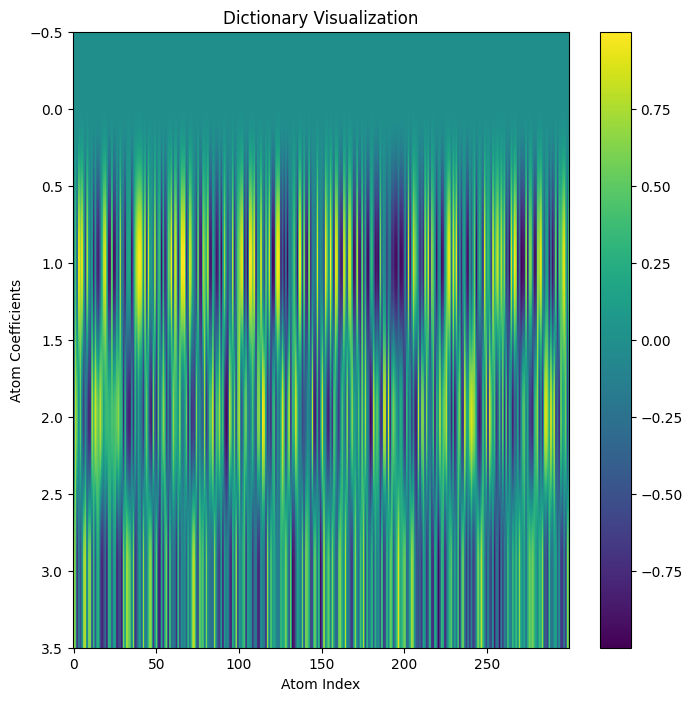

In [252]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_dictionary_as_image(D, cmap='viridis'):
    """
    Visualizes the entire dictionary D as a single image.

    Args:
        D: The dictionary matrix of shape (atom_size, number_of_atoms).
        cmap: Colormap for visualization.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(D, aspect='auto', cmap=cmap)
    plt.colorbar()
    plt.title("Dictionary Visualization")
    plt.xlabel("Atom Index")
    plt.ylabel("Atom Coefficients")
    plt.show()

visualize_dictionary_as_image(D)

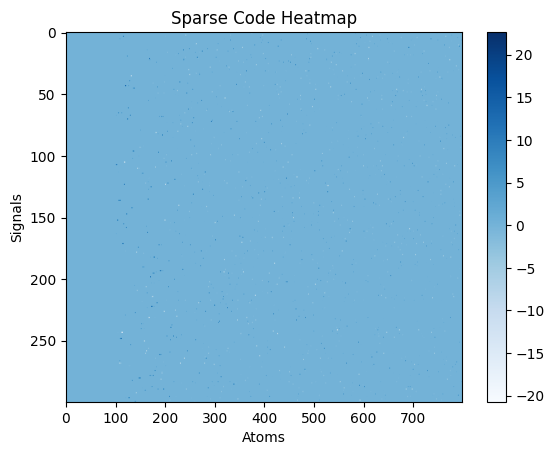

In [253]:
def plot_sparse_code(X):
    plt.imshow(X.toarray(), aspect='auto', cmap='Blues')
    plt.colorbar()
    plt.title('Sparse Code Heatmap')
    plt.xlabel('Atoms')
    plt.ylabel('Signals')
    plt.show()
plot_sparse_code(X)

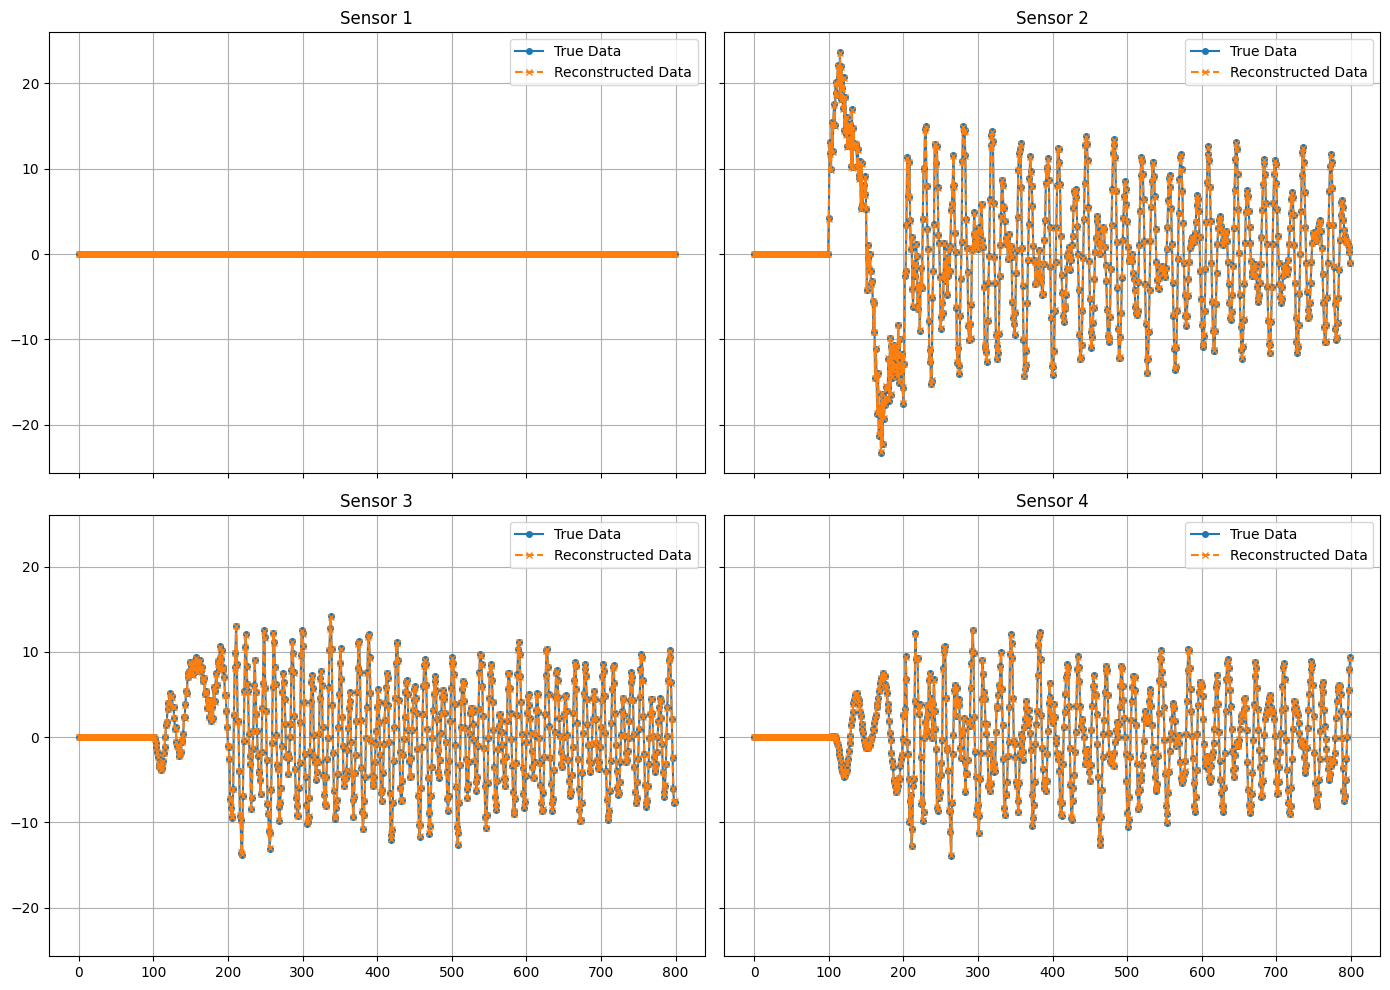

In [254]:
train_reconstructed = D.dot(X.toarray())


def plot_comparison(test_data, reconstructed_data):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), sharex=True, sharey=True)
    axes = axes.flatten()  # 将二维的axes数组转换为一维，方便迭代
    sensor_labels = ['Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']

    for i in range(4):
        axes[i].plot(test_data[i], label='True Data', marker='o', linestyle='-', markersize=4)
        axes[i].plot(reconstructed_data[i], label='Reconstructed Data', marker='x', linestyle='--', markersize=4)
        axes[i].set_title(sensor_labels[i])
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

# 假设 test_data 和 Y_reconstructed 都已经正确计算
plot_comparison(train_data, train_reconstructed)


In [265]:
# 创建测量矩阵
def create_measurement_matrix():
    Phi = np.zeros((2, 4))
    # Phi[0, 1] = 1  # 选择第一个自由度
    Phi[0, 2] = 1  # 选择第2个自由度
    Phi[1, 3] = 1  # 选择第三个自由度
    return Phi

Phi = create_measurement_matrix()
print(Phi)

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]]


(4, 300)
Y_test shape: (2, 300)
D_transformed shape: (2, 300)


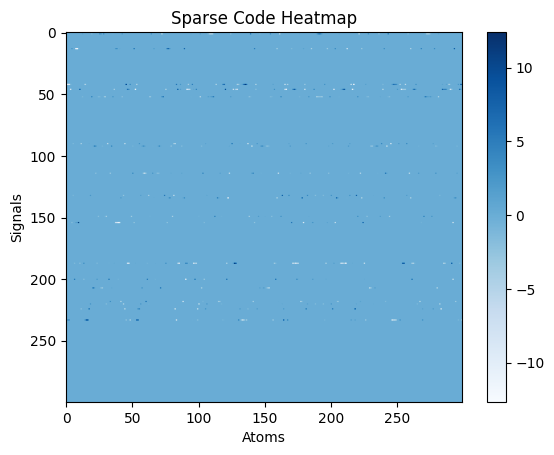

In [266]:
def reconstruct_full_data(Y_test, D, Phi, lambda1):
    # 确保字典和测试数据是正确的 Fortran 格式和数据类型
    D_fortran = np.asfortranarray(D.astype(np.float64))
    Y_test_fortran = np.asfortranarray(Y_test.astype(np.float64))
    print(D_fortran.shape)
    # 应用测量矩阵 Phi 到 D
    D_transformed = np.dot(Phi, D_fortran)
    D_transformed_fortran = np.asfortranarray(D_transformed)

    # 确保维度匹配
    print("Y_test shape:", Y_test_fortran.shape)
    print("D_transformed shape:", D_transformed_fortran.shape)

    # 执行lasso操作
    X_test = spams.lasso(Y_test_fortran, D=D_transformed_fortran, lambda1=lambda1, numThreads=-1)
    return X_test


X_measure = reconstruct_full_data(meas_data, D, Phi, 0.1)
plot_sparse_code(X_measure)

# 如果需要，展示或验证重构的结果

In [267]:
# 假设 D 和 X_test 已定义
# 假定D是密集矩阵，X_test是稀疏矩阵
Y_reconstructed = D.dot(X_measure.toarray())

print((Y_reconstructed))

[[ 5.48883850e-213  7.22187692e-213  6.63075754e-213 ... -4.69712491e-214
  -4.77090342e-213 -6.56096338e-213]
 [-3.18522751e-001 -1.34434584e-001 -1.48111421e-001 ...  4.09032612e-001
   2.96018706e-001 -5.90150901e-002]
 [ 8.58084953e+000  9.27497716e+000  8.63597716e+000 ... -5.95219132e+000
  -7.65824953e+000 -7.54417717e+000]
 [-8.86075094e+000 -1.04271661e+001 -9.59376606e+000 ...  5.48388074e+000
   7.88655094e+000  9.32556605e+000]]


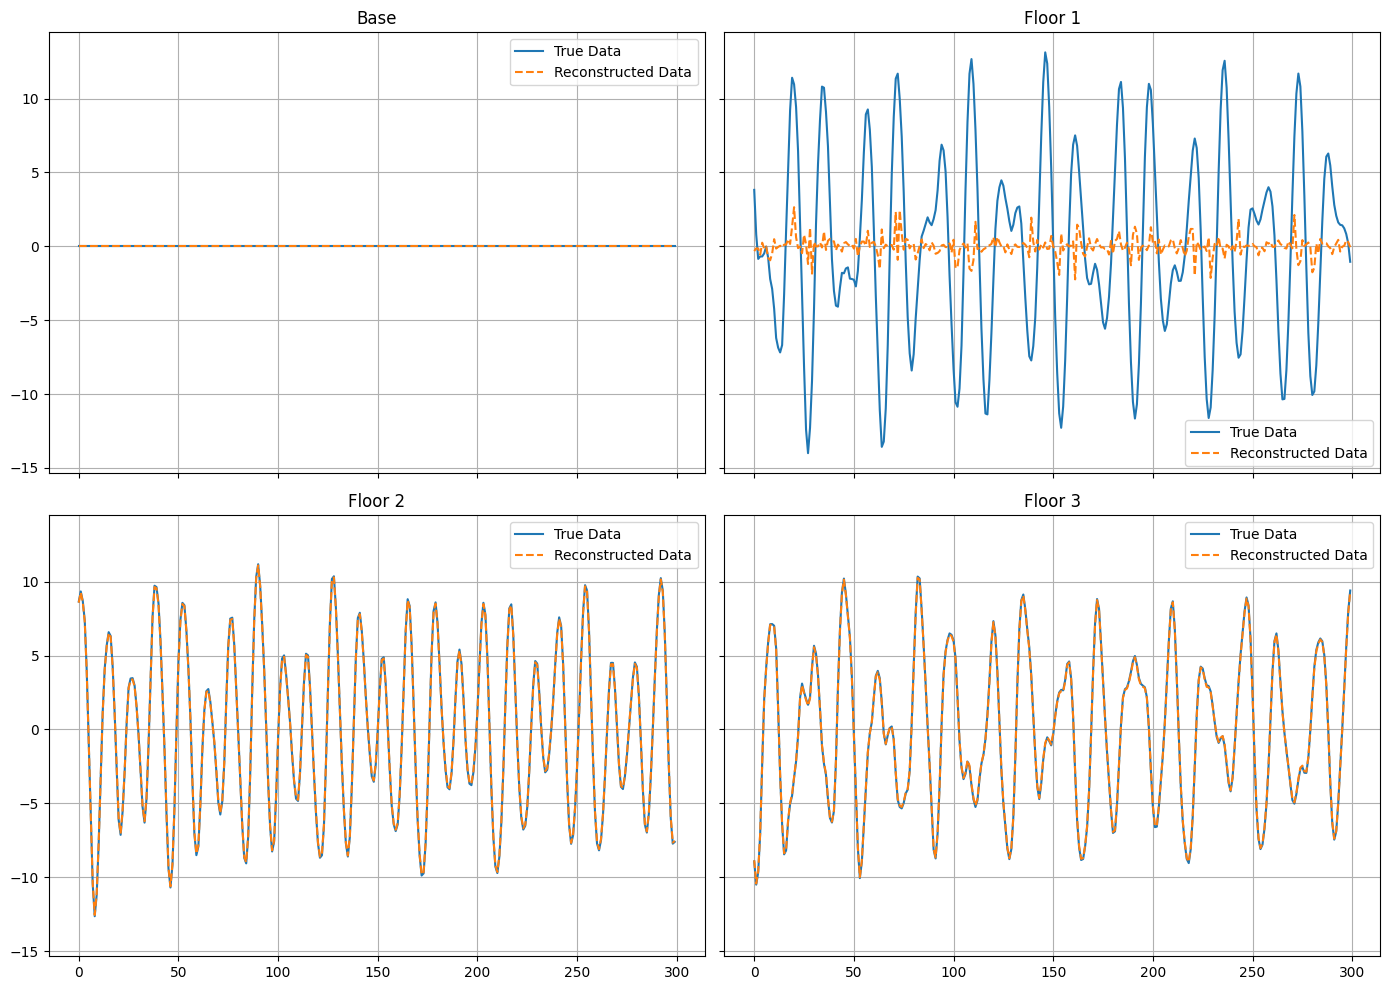

In [268]:
def plot_comparison(test_data, reconstructed_data):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), sharex=True, sharey=True)
    axes = axes.flatten()  # 将二维的axes数组转换为一维，方便迭代
    sensor_labels = ['Base', 'Floor 1', 'Floor 2', 'Floor 3']

    for i in range(4):
        axes[i].plot(test_data[i], label='True Data', linestyle='-', markersize=4)
        axes[i].plot(reconstructed_data[i], label='Reconstructed Data', linestyle='--', markersize=4)
        axes[i].set_title(sensor_labels[i])
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

# 假设 test_data 和 Y_reconstructed 都已经正确计算
plot_comparison(test_data, Y_reconstructed)

